In [1]:
# Standard library imports
from argparse import ArgumentParser
import os, sys
THIS_DIR = os.path.abspath('')
PARENT_DIR = os.path.dirname(os.path.abspath(''))
sys.path.append(PARENT_DIR)

# Third party imports
import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint
from torchdiffeq import odeint
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
import imageio

# local application imports
from lag_caVAE.lag import Lag_Net
from lag_caVAE.nn_models import MLP_Encoder, MLP, MLP_Decoder, PSD
from hyperspherical_vae.distributions import VonMisesFisher
from hyperspherical_vae.distributions import HypersphericalUniform
from utils import arrange_data, from_pickle, my_collate, ImageDataset
from examples.cart_lag_cavae_trainer import Model as Model_lag_cavae
from ablations.ablation_cart_MLPdyna_cavae_trainer import Model as Model_MLPdyna_cavae
from ablations.ablation_cart_lag_vae_trainer import Model as Model_lag_vae
from ablations.ablation_cart_lag_MLPEnc_caDec_trainer import Model as Model_lag_MLPEnc_caDec
from ablations.ablation_cart_lag_caEnc_MLPDec_trainer import Model as Model_lag_caEnc_MLPDec
from ablations.ablation_cart_lag_caAE_trainer import Model as Model_lag_caAE
from ablations.HGN import Model as Model_HGN

seed_everything(0)
%matplotlib inline
DPI = 600

# https://stackoverflow.com/questions/53472940/nameerror-name-base-is-not-defined-openai-gym
import pyvirtualdisplay

_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                    size=(1400, 900))
_ = _display.start()

In [2]:
checkpoint_path = os.path.join(PARENT_DIR, 
                               'checkpoints', 
                               'updated-cart-lag-cavae-T_p=4-epoch=905.ckpt')
model_lag_cavae = Model_lag_cavae.load_from_checkpoint(checkpoint_path)

checkpoint_path = os.path.join(PARENT_DIR, 
                               'checkpoints', 
                               'ablation-cart-MLPdyna-cavae-T_p=4-epoch=807.ckpt')
model_MLPdyna_cavae = Model_MLPdyna_cavae.load_from_checkpoint(checkpoint_path)

checkpoint_path = os.path.join(PARENT_DIR, 
                               'checkpoints', 
                               'ablation-cart-lag-vae-T_p=4-epoch=987.ckpt')
model_lag_vae = Model_lag_vae.load_from_checkpoint(checkpoint_path)

checkpoint_path = os.path.join(PARENT_DIR, 
                               'checkpoints', 
                               'ablation-cart-lag-MLPEnc-caDec-T_p=4-epoch=524.ckpt')
model_lag_MLPEnc_caDec = Model_lag_MLPEnc_caDec.load_from_checkpoint(checkpoint_path)

# this checkpoint is trained with learning rate 1e-4
checkpoint_path = os.path.join(PARENT_DIR, 
                               'checkpoints', 
                               'ablation-cart-lag-caEnc-MLPDec-T_p=4-epoch=954.ckpt')
model_lag_caEnc_MLPDec = Model_lag_caEnc_MLPDec.load_from_checkpoint(checkpoint_path)

# this checkpoint is trained with learning rate 1e-4
checkpoint_path = os.path.join(PARENT_DIR, 
                               'checkpoints', 
                               'ablation-cart-lag-caAE-T_p=4-epoch=909.ckpt')
model_lag_caAE = Model_lag_caAE.load_from_checkpoint(checkpoint_path)

checkpoint_path = os.path.join(PARENT_DIR, 
                               'checkpoints', 
                               'baseline-cart-HGN-T_p=4-epoch=1777.ckpt')
model_HGN = Model_HGN.load_from_checkpoint(checkpoint_path)

In [3]:
# Load data, prepare for plotting prediction
data_path=os.path.join(PARENT_DIR, 'datasets', 'cartpole-gym-image-dataset-rgb-u9-test.pkl')
test_dataset = ImageDataset(data_path, 19, ctrl=False)
# select a particular trajectory
batch_idx = 10

In [4]:
test_dataset.x.shape

(20, 256, 3, 64, 64)

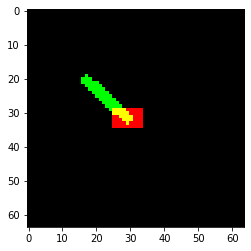

In [5]:
# plot initial configuration
plt.imshow(np.moveaxis(test_dataset.x[0,batch_idx], 0, 2))

/home/z0042y5x/.pyenv/versions/3.7.5/envs/lag/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


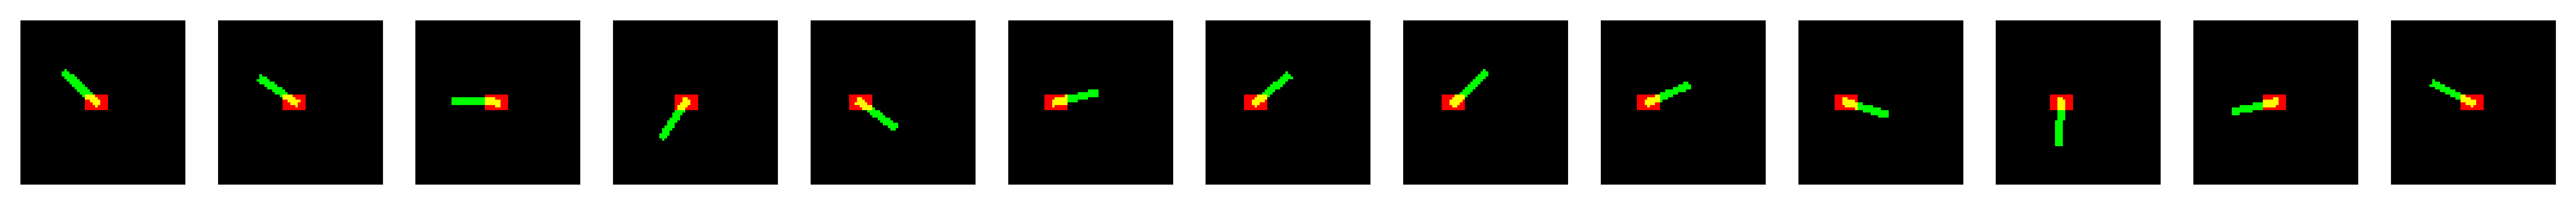

In [6]:
# plot true sequence
r0, cos_phi0, sin_phi0 = test_dataset.obs[0,batch_idx,0], test_dataset.obs[0,batch_idx,1], test_dataset.obs[0,batch_idx,2]
r_dot0, phi_dot0 = test_dataset.obs[0,batch_idx,3], test_dataset.obs[0,batch_idx,4]
phi0 = np.arctan2(sin_phi0, cos_phi0)

import gym, myenv
env = gym.make('My_FA_CartPole-v0')
env.reset()
env.state = np.array([r0, r_dot0, phi0, phi_dot0], dtype=np.float32)
frame = env.render(mode='rgb_array')
frames = [frame]

for i in range(59):
    env.step([0, 0])
    frame = env.render(mode='rgb_array')
    frames.append(frame)
env.close()

fig = plt.figure(figsize=(16, 4), dpi=DPI)
for i in range(13):
    plt.subplot(1, 13, i+1)
    plt.imshow(frames[i*4])
    plt.axis('off')
# fig.savefig(os.path.join(PARENT_DIR, 'figures', f'true_cart_seq.png'), bbox_inches='tight')

In [7]:
# save gif
# imageio.mimsave(os.path.join(PARENT_DIR, 'figures', 'true_cart_seq.gif'), frames, duration=0.05)

In [8]:
# prepare plot prediction
X = torch.tensor(test_dataset.x[0:2, batch_idx], dtype=torch.float32).view(2, 1, 3, 64, 64)
u = torch.tensor([0.0, 0.0], dtype=torch.float32).view(1,2)

timesteps = 60
t_eval = np.linspace(0, timesteps-1, timesteps) * 0.05
t_eval = torch.tensor(t_eval, dtype=torch.float32)

def plot_prediction(model, name, solver='rk4'):
    model.t_eval = t_eval
    model.hparams.solver = solver
    model(X, u)
    print(name)
    fig = plt.figure(figsize=(16, 4), dpi=DPI)
    for i in range(13):
        plt.subplot(1, 13, i+1)
        plt.imshow(model.Xrec[i*4, 0].permute(1,2,0).detach().cpu().numpy())
        plt.axis('off')
#     fig.savefig(os.path.join(PARENT_DIR, 'figures', f'prediction_cart_{name}.png'), bbox_inches='tight')
#     imageio.mimsave(os.path.join(PARENT_DIR, 'figures', f'prediction_cart_{name}.gif'), 
#                     (model.Xrec[:, 0].permute(0,2,3,1).detach().cpu().numpy().clip(min=0, max=1)*255).astype(np.uint8), 
#                     duration=0.05)

/home/z0042y5x/.pyenv/versions/3.7.5/envs/lag/lib/python3.7/site-packages/torch/nn/functional.py:3447: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/z0042y5x/.pyenv/versions/3.7.5/envs/lag/lib/python3.7/site-packages/torch/nn/functional.py:3384: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0

lag_cavae


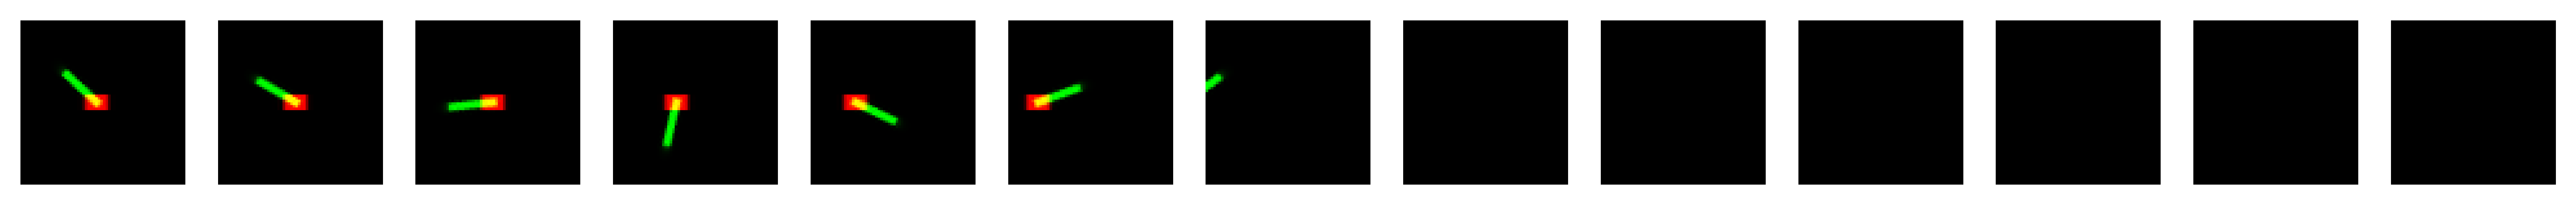

In [9]:
plot_prediction(model_lag_cavae, 'lag_cavae')

In [10]:
 model_lag_cavae.Xrec.shape

torch.Size([60, 1, 3, 64, 64])

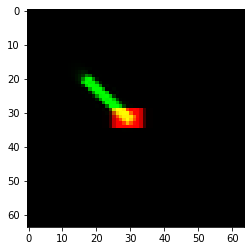

In [11]:
temp = (model_lag_cavae.Xrec[0,0].permute(1,2,0).detach().cpu().numpy().clip(min=0, max=1) *255).astype(np.uint8)
plt.imshow(temp)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

lag_vae


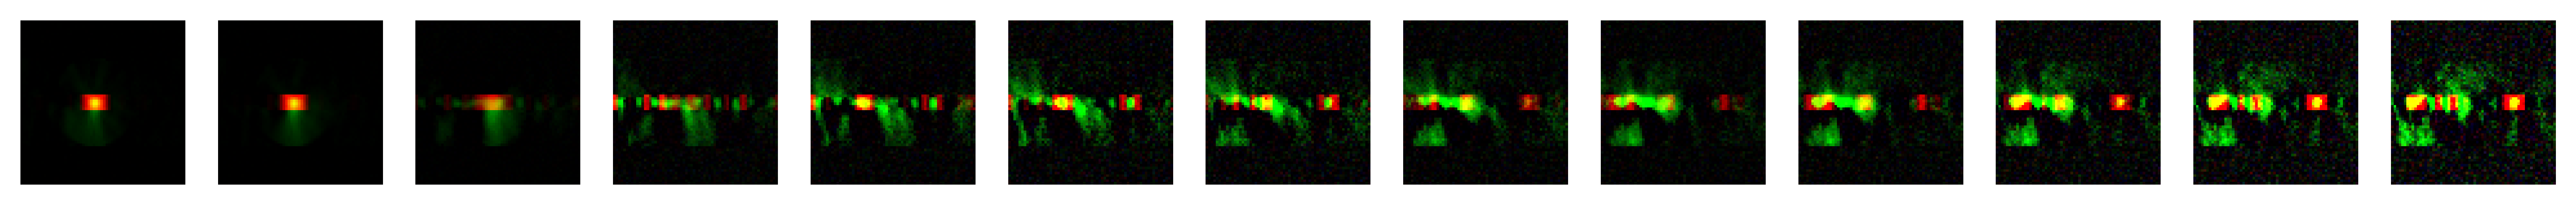

In [12]:
plot_prediction(model_lag_vae, 'lag_vae')

MLPdyna_cavae


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

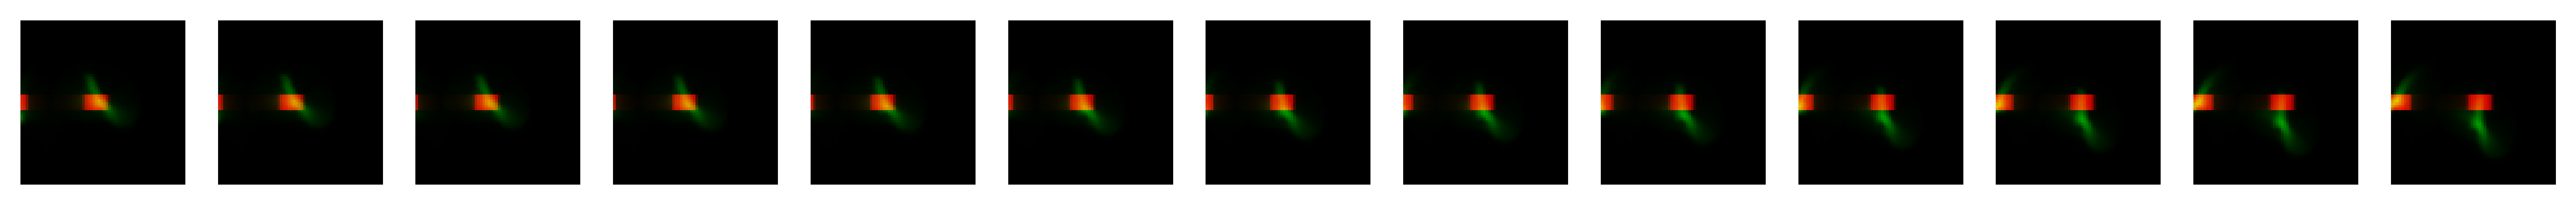

In [13]:
plot_prediction(model_MLPdyna_cavae, 'MLPdyna_cavae')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


lag_MLPEnc_caDec


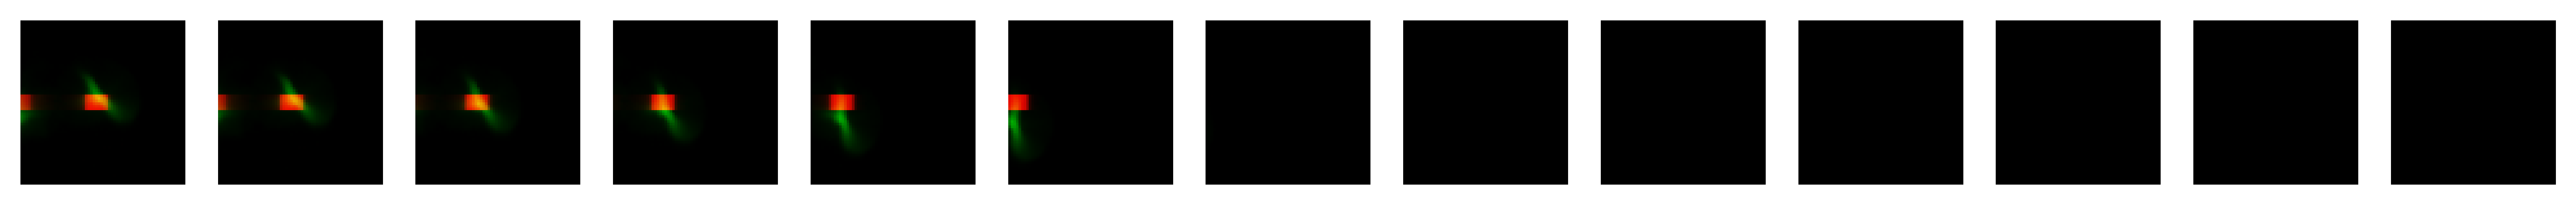

In [14]:
plot_prediction(model_lag_MLPEnc_caDec, 'lag_MLPEnc_caDec')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

lag_caEnc_MLPDec


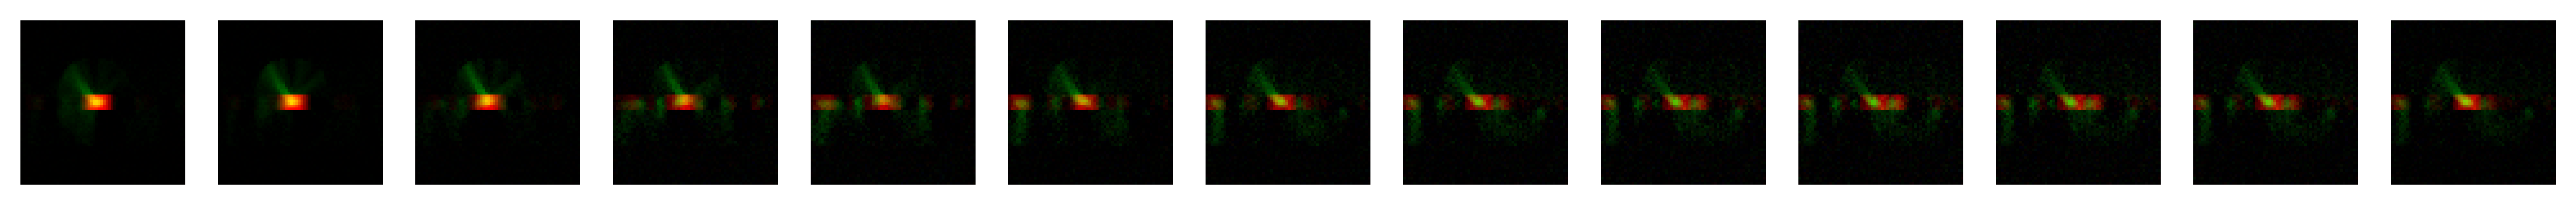

In [15]:
plot_prediction(model_lag_caEnc_MLPDec, 'lag_caEnc_MLPDec')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

lag_caAE


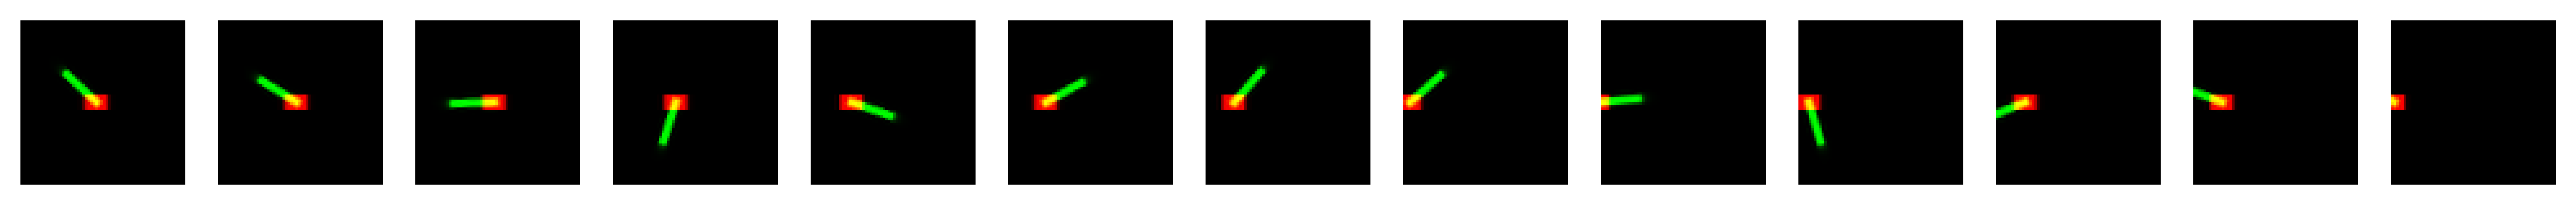

In [16]:
plot_prediction(model_lag_caAE, 'lag_caAE')

In [17]:
X = torch.tensor(test_dataset.x[0:5, 10], dtype=torch.float32).view(5, 1, 3, 64, 64)
[T, bs, c, _, _] = X[0:5].shape
X_0_5 = F.interpolate(X[0:5].view(T*bs, c, 64, 64), size=[32, 32]).view(T, bs, c, 32, 32)

HGN


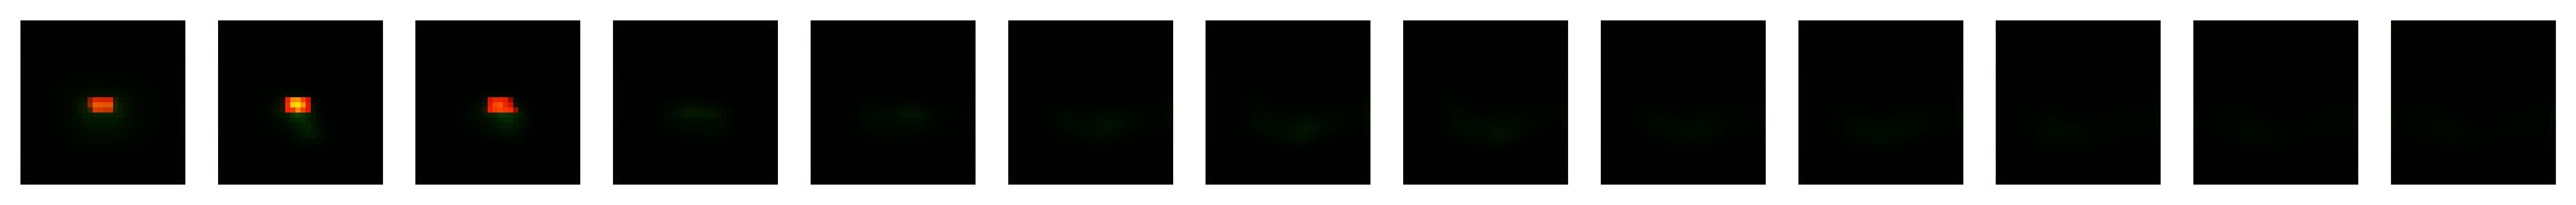

In [18]:
model = model_HGN ; solver = 'rk4' ; name = 'HGN'
model.t_eval = t_eval
model.hparams.solver = solver
model.step = 3 ; model.alpha = 1
model(X_0_5)
print(name)
fig = plt.figure(figsize=(16, 4), dpi=DPI)
for i in range(13):
    plt.subplot(1, 13, i+1)
    plt.imshow(model.Xrec[i*4, 0].permute(1,2,0).detach().cpu().numpy())
    plt.axis('off')
# fig.savefig(os.path.join(PARENT_DIR, 'figures', f'prediction_cart_{name}'), bbox_inches='tight')

In [19]:
# imageio.mimsave(os.path.join(PARENT_DIR, 'figures', 'prediction_cart_HGN.gif'), 
#                 (model.Xrec[:, 0].permute(0,2,3,1).detach().cpu().numpy().clip(min=0, max=1)*255).astype(np.uint8), 
#                 duration=0.05)